In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from scipy.stats import norm, skew, probplot
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score

/home/bob/anaconda3/envs/Ad/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# EDA - Exploratory Data Analysis

In [3]:
data = pd.read_csv("ad_click_dataset.csv")
data

,id,full_name,age,gender,device_type,ad_position,browsing_history,time_of_day,click
0,670,User670,22.0,NaN,Desktop,Top,Shopping,Afternoon,1
1,3044,User3044,NaN,Male,Desktop,Top,NaN,NaN,1
2,5912,User5912,41.0,Non-Binary,NaN,Side,Education,Night,1
3,5418,User5418,34.0,Male,NaN,NaN,Entertainment,Evening,1
4,9452,User9452,39.0,Non-Binary,NaN,NaN,Social Media,Morning,0
...,...,...,...,...,...,...,...,...,...
9995,8510,User8510,NaN,NaN,Mobile,Top,Education,NaN,0
9996,7843,User7843,NaN,Female,Desktop,Bottom,Entertainment,NaN,0
9997,3914,User3914,NaN,Male,Mobile,Side,NaN,Morning,0
9998,7924,User7924,NaN,NaN,Desktop,NaN,Shopping,Morning,1


In [3]:
data = data.drop(columns=['id','full_name'], axis=1)

In [4]:
data.shape

(10000, 7)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               5234 non-null   float64
 1   gender            5307 non-null   object 
 2   device_type       8000 non-null   object 
 3   ad_position       8000 non-null   object 
 4   browsing_history  5218 non-null   object 
 5   time_of_day       8000 non-null   object 
 6   click             10000 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 547.0+ KB


In [6]:
num_cols = data.select_dtypes(include=['float64', 'int64'])
cat_cols = data.select_dtypes(include=['object'])

print('Numeric Variables:')
print(num_cols.columns.tolist())

print("\nCategorical Variables:")
print(cat_cols.columns.tolist())

Numeric Variables:
['age', 'click']

Categorical Variables:
['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']


In [7]:
for col in cat_cols:
        print('We Have {} Unique values. Values in the {} Column: {}'.format(len(data[col].unique()),col,data[col].unique()))
        print('__'*30)

We Have 4 Unique values. Values in the gender Column: [nan 'Male' 'Non-Binary' 'Female']
____________________________________________________________
We Have 4 Unique values. Values in the device_type Column: ['Desktop' nan 'Mobile' 'Tablet']
____________________________________________________________
We Have 4 Unique values. Values in the ad_position Column: ['Top' 'Side' nan 'Bottom']
____________________________________________________________
We Have 6 Unique values. Values in the browsing_history Column: ['Shopping' nan 'Education' 'Entertainment' 'Social Media' 'News']
____________________________________________________________
We Have 5 Unique values. Values in the time_of_day Column: ['Afternoon' nan 'Night' 'Evening' 'Morning']
____________________________________________________________


In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,5234.0,40.197363,13.126420,18.0,29.0,39.5,52.0,64.0
click,10000.0,0.650000,0.476993,0.0,0.0,1.0,1.0,1.0


In [9]:
for feature in num_cols:
    zero_values = (data[feature] == 0).sum()
    null_values = data[feature].isnull().sum()
    unique_values = len(data[feature].unique())
    
    print(f"Feature: {feature}")
    print(f"Number of 0 Values: {zero_values}")
    print(f"Number of Null Values: {null_values}")
    print(f"Unique Values: {unique_values}")
    print("="*30)

Feature: age
Number of 0 Values: 0
Number of Null Values: 4766
Unique Values: 48
Feature: click
Number of 0 Values: 3500
Number of Null Values: 0
Unique Values: 2


# Missing Values

In [10]:
data.isnull().sum()

age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64

<Axes: title={'center': 'Heatmap for the null values in each column'}>

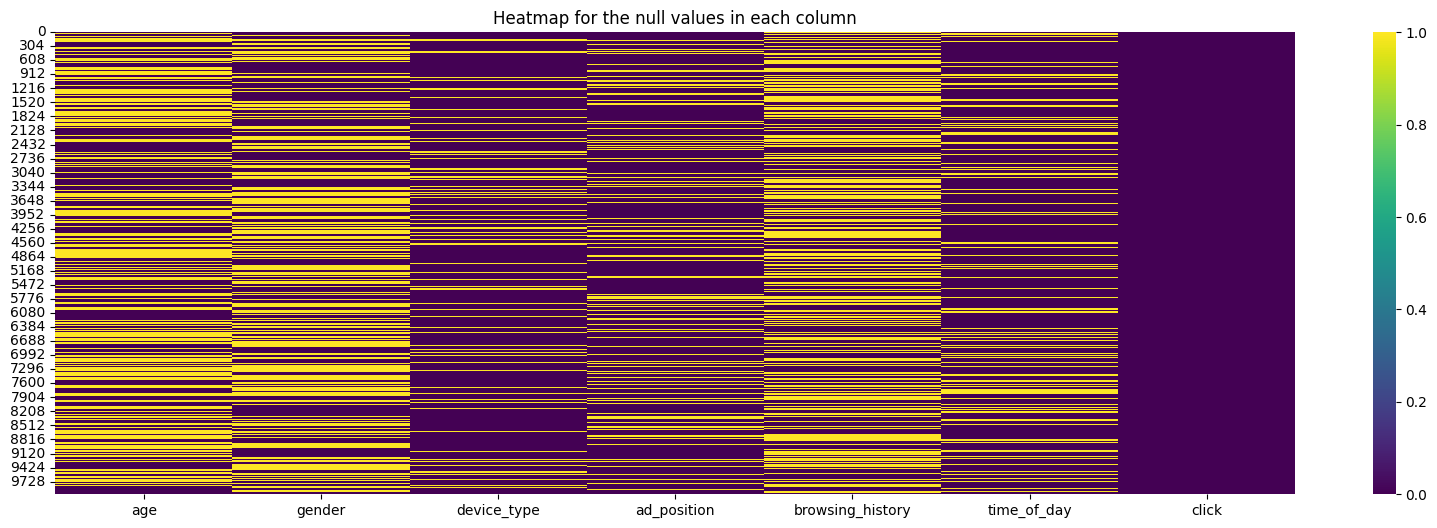

In [11]:
plt.figure(figsize=(20,6))
plt.title('Heatmap for the null values in each column')
sns.heatmap(data.isnull(),cmap='viridis')

**I fill the categorical null data with Unknown.**

In [12]:
data['gender'] = data['gender'].fillna('Unknown')
data['device_type'] = data['device_type'].fillna('Unknown')
data['ad_position'] = data['ad_position'].fillna('Unknown')
data['browsing_history'] = data['browsing_history'].fillna('Unknown')
data['time_of_day'] = data['time_of_day'].fillna('Unknown')

**I plan to apply the KNN imputation method to fill in the missing values ​​in the Age column. First, I will analyze the rows with missing values ​​to determine the appropriate neighbors.**

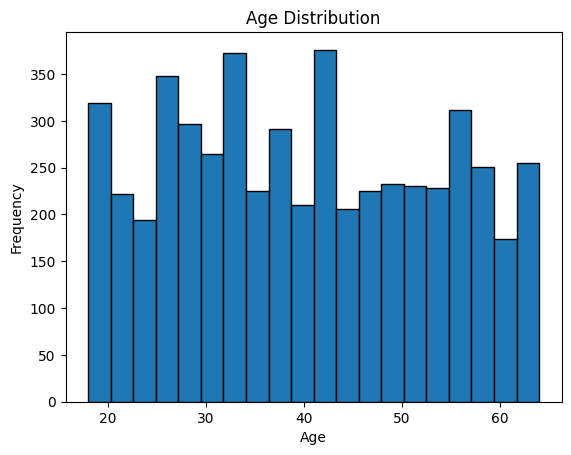

In [13]:
plt.hist(data['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [14]:
def knn_impute(data, n_neighbors=5):   
    data_encoded = data.copy()
    
    category_mappings = {}
    for col in data_encoded.select_dtypes(include='object').columns:
        data_encoded[col] = data_encoded[col].astype('category').cat.codes
        category_mappings[col] = dict(enumerate(data[col].astype('category').cat.categories))

    knn_imputer = KNNImputer(n_neighbors=n_neighbors)
    data_imputed = pd.DataFrame(knn_imputer.fit_transform(data_encoded), columns=data_encoded.columns)

    for col in data.select_dtypes(include='object').columns:
        data_imputed[col] = data_imputed[col].round().astype(int).map(category_mappings[col])
        
    return data_imputed

data_imputed = knn_impute(data, n_neighbors=5)
data = data_imputed

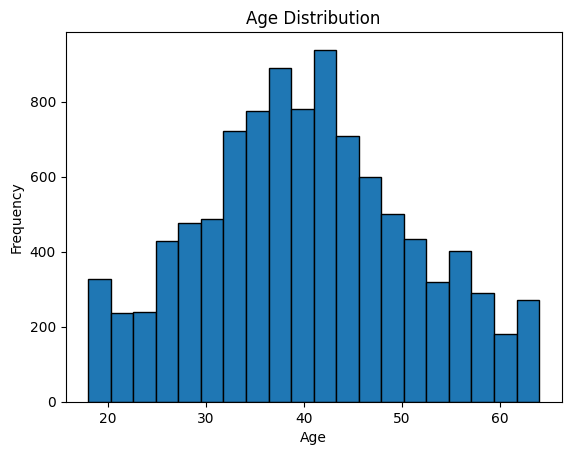

In [15]:
plt.hist(data['age'], bins=20, edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [16]:
data.isnull().sum()

age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64

# Correlation

In [17]:
corr = num_cols.corr()
top_corr = corr['click'].sort_values(ascending=False)[1:20].to_frame()
styled_corr = top_corr.style.background_gradient(axis=1, cmap=sns.light_palette('green', as_cmap=True))
styled_corr

,click
age,-0.082056


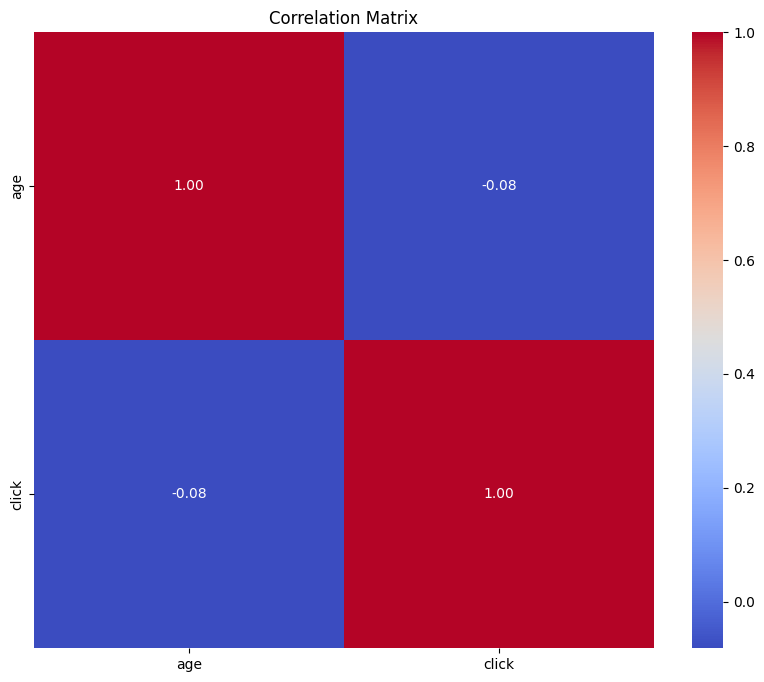

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

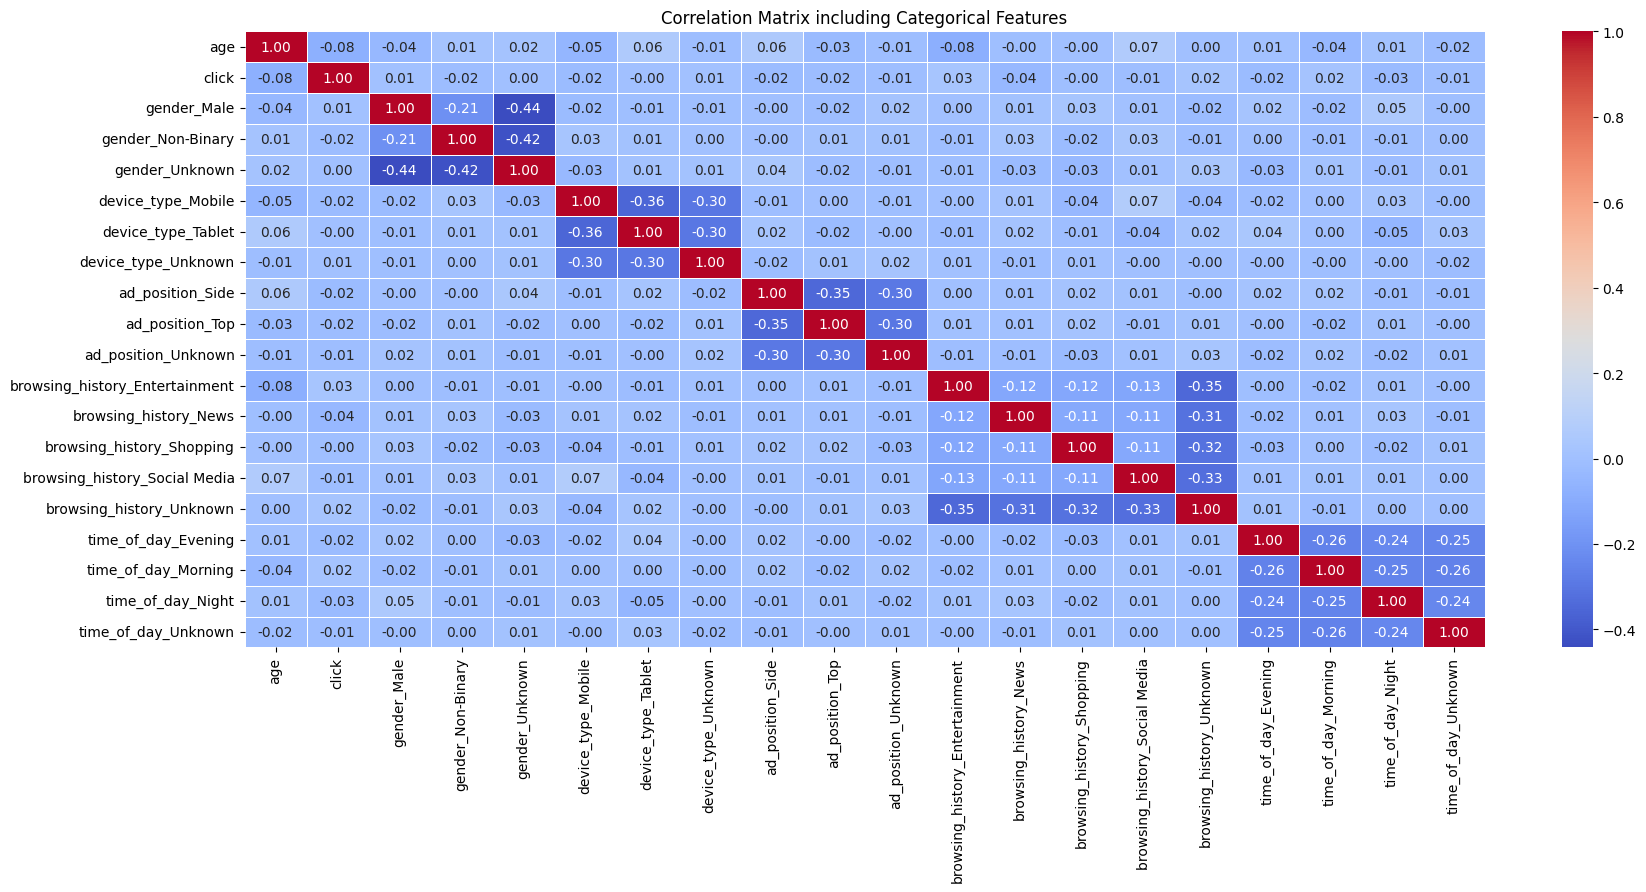

In [19]:
data_encoded = pd.get_dummies(data, drop_first=True)
corr_matrix = data_encoded.corr()

# Heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()


In [20]:
top_corr = corr_matrix['click'].sort_values(ascending=False)[1:20].to_frame()
styled_corr = top_corr.style.background_gradient(axis=1, cmap=sns.light_palette('green', as_cmap=True))
styled_corr

,click
browsing_history_Entertainment,0.028810
browsing_history_Unknown,0.023378
time_of_day_Morning,0.016449
gender_Male,0.007896
device_type_Unknown,0.005241
gender_Unknown,0.000231
device_type_Tablet,-0.002415
browsing_history_Shopping,-0.003238
time_of_day_Unknown,-0.008386
ad_position_Unknown,-0.009435


# Outlier

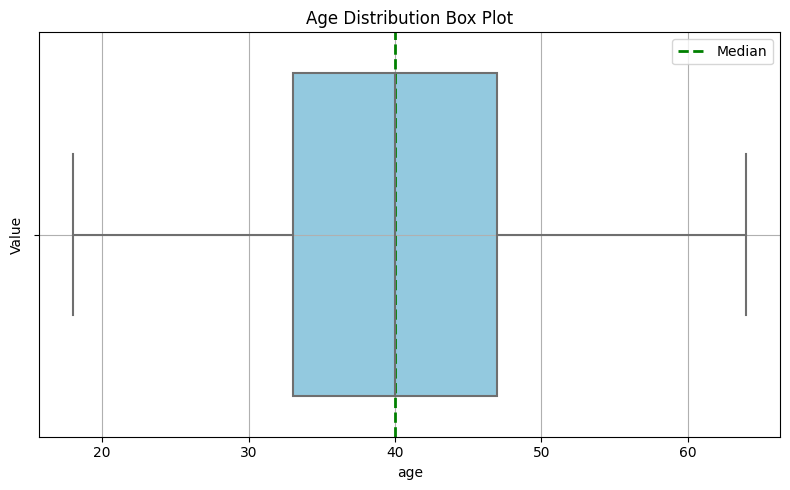

In [21]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x="age", color='skyblue', flierprops=dict(marker='o', markersize=8, markerfacecolor='red'))
plt.title('Age Distribution Box Plot')
plt.xlabel('age')
plt.ylabel('Value')
median_age = data['age'].median()
plt.axvline(median_age, color='green', linestyle='--', linewidth=2, label='Median')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
min_age = data['age'].min()
max_age = data['age'].max()

print(f"Minimum age value: {min_age}")
print(f"Maximum age value: {max_age}")

Minimum age value: 18.0
Maximum age value: 64.0


**No Outliers**

In [23]:
data['age'] = data['age'].astype(int)
data['click'] = data['click'].astype(int)

# Visualizations

## Click

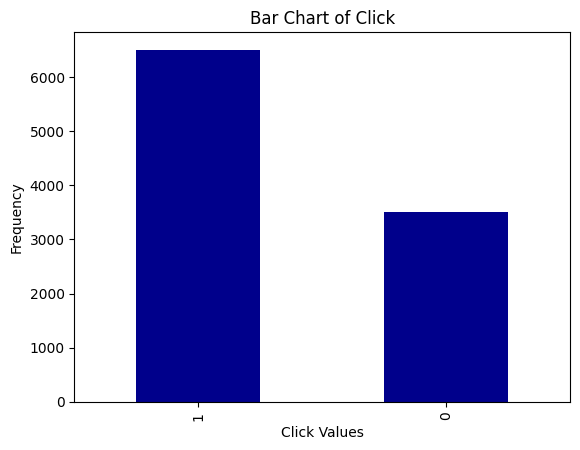

In [24]:
data['click'].value_counts().plot(kind='bar', color='darkblue')
plt.xlabel('Click Values')
plt.ylabel('Frequency')
plt.title('Bar Chart of Click')
plt.show()


In [25]:
distribution_click = data['click'].value_counts(normalize=True) * 100

print(distribution_click)

click
1    65.0
0    35.0
Name: proportion, dtype: float64


> **Distribution is Imbalanced. Smote or other methods can be considered to balance this.**

## Age

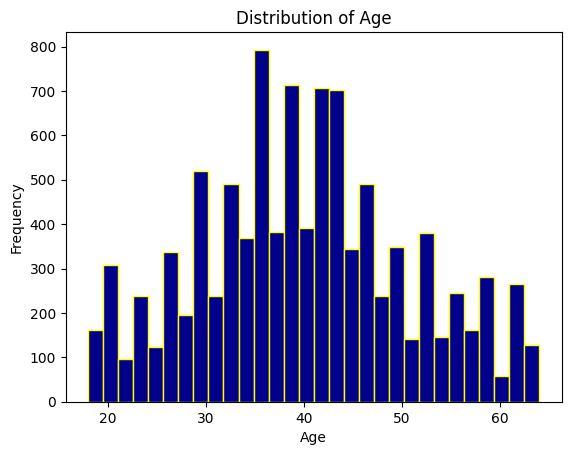

In [26]:
plt.hist(data['age'], bins=30, color='darkblue', edgecolor='yellow')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

<Figure size 1200x600 with 0 Axes>

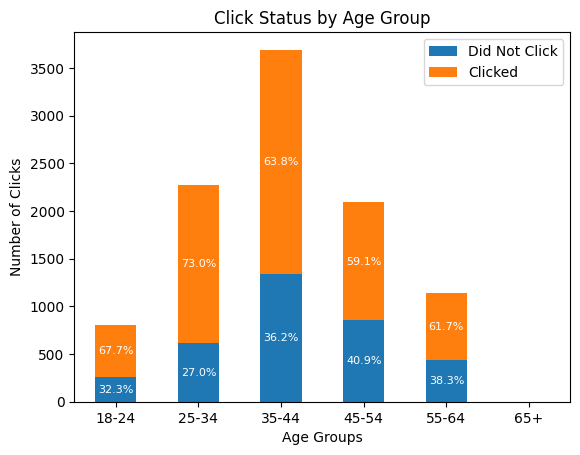

In [27]:
# Defining age group boundaries
bins = [17, 24, 34, 44, 54, 64, 100]
labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']

grouped = (
    data.assign(age_group=pd.cut(data['age'], bins=bins, labels=labels))
    .groupby(['age_group', 'click'], observed=False)
    .size()
    .unstack(fill_value=0)
)

percentages = grouped.div(grouped.sum(axis=1), axis=0) * 100
plt.figure(figsize=(12, 6)) 
ax = grouped.plot(kind='bar', stacked=True)
plt.title('Click Status by Age Group')
plt.xlabel('Age Groups')
plt.ylabel('Number of Clicks')
plt.xticks(rotation=0)
plt.legend(['Did Not Click', 'Clicked'])

# Adding percentage labels on the bars
for i in range(len(grouped)):
    total = grouped.iloc[i].sum()
    for j in range(len(grouped.columns)):
        if total > 0:
            percentage = (grouped.iloc[i, j] / total) * 100
            ax.text(i, grouped.iloc[i, :j+1].sum() - grouped.iloc[i, j] / 2, f'{percentage:.1f}%', 
                    ha='center', va='center', color='white', fontsize=8)

plt.show()

> **According to the data, there are no users over the age of 65. The largest user group is in the 35-44 age range, followed by the 25-34 age group. Next is the 45-54 age group, followed by the 55-64 age range, while the least number of users belongs to the 18-24 age group.**

> **The age group with the highest click-through rate for advertisements is 25-34 years old. This is followed by the 18-24 age group, then the 35-44 and 55-64 age groups. The lowest click-through rate is found in the 45-54 age group.**

## Gender

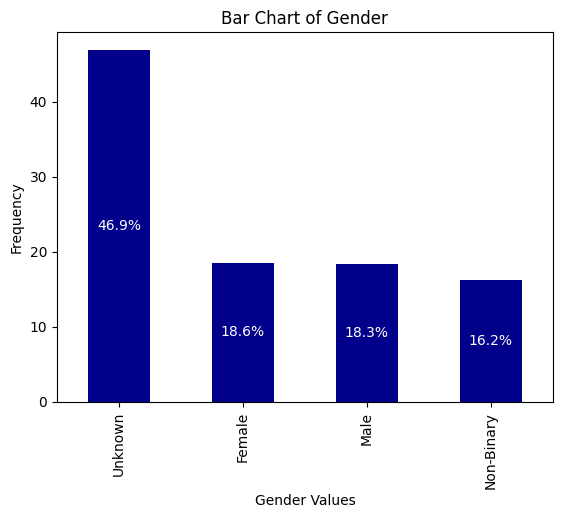

In [28]:
click_counts = data[data['click'] == 1]['gender'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Gender Values')
plt.ylabel('Frequency')
plt.title('Bar Chart of Gender')

for i in range(len(click_counts)):
    percentage = click_counts.iloc[i]
    ax.text(i, percentage / 2, f'{percentage:.1f}%', 
            ha='center', va='center', color='white', fontsize=10)

plt.show()

> **Almost half of the users genders are unknown. However, the distribution ratios of those whose genders are known are almost similar.**

## Device Type

In [29]:
data['device_type'].value_counts()

device_type
Desktop    2754
Mobile     2649
Tablet     2597
Unknown    2000
Name: count, dtype: int64

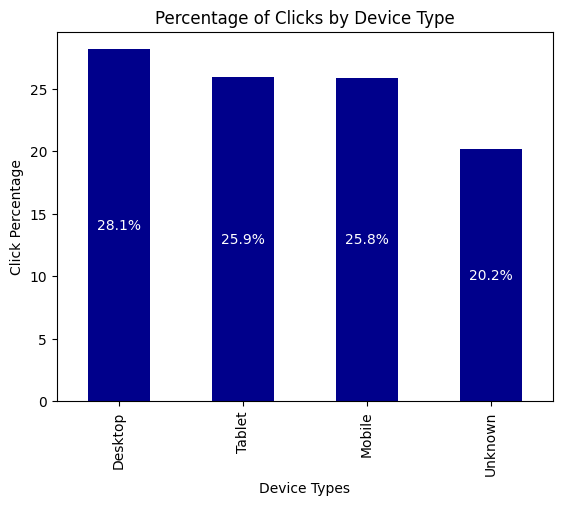

In [30]:
click_counts = data[data['click'] == 1]['device_type'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Device Types')
plt.ylabel('Click Percentage')
plt.title('Percentage of Clicks by Device Type')

for i in range(len(click_counts)):
    percentage = click_counts.iloc[i]
    ax.text(i, percentage / 2, f'{percentage:.1f}%', 
            ha='center', va='center', color='white', fontsize=10)

plt.show()

> **The most clicks on the ads came from Desktop. Click rates from tablet and mobile are very close to each other. There is a 20% rate where the device used for the click is unknown.**

## Ad Position

In [31]:
data['ad_position'].value_counts()

ad_position
Bottom     2817
Top        2597
Side       2586
Unknown    2000
Name: count, dtype: int64

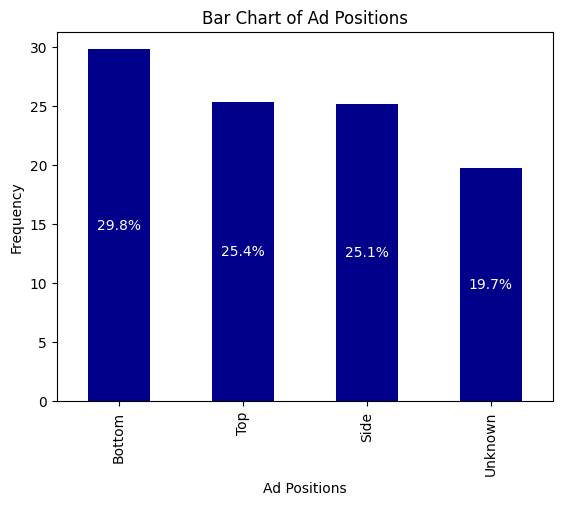

In [32]:
click_counts = data[data['click'] == 1]['ad_position'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Ad Positions')
plt.ylabel('Frequency')
plt.title('Bar Chart of Ad Positions')

for i in range(len(click_counts)):
    percentage = click_counts.iloc[i]
    ax.text(i, percentage / 2, f'{percentage:.1f}%', 
            ha='center', va='center', color='white', fontsize=10)

plt.show()

> **Ads on the bottom were clicked the most. Top and Side ads have similar click-through rates. 19.7% clicked in an unknown position**

## Browsing History

In [33]:
data['browsing_history'].value_counts()

browsing_history
Unknown          4782
Entertainment    1175
Social Media     1054
Education        1029
Shopping          984
News              976
Name: count, dtype: int64

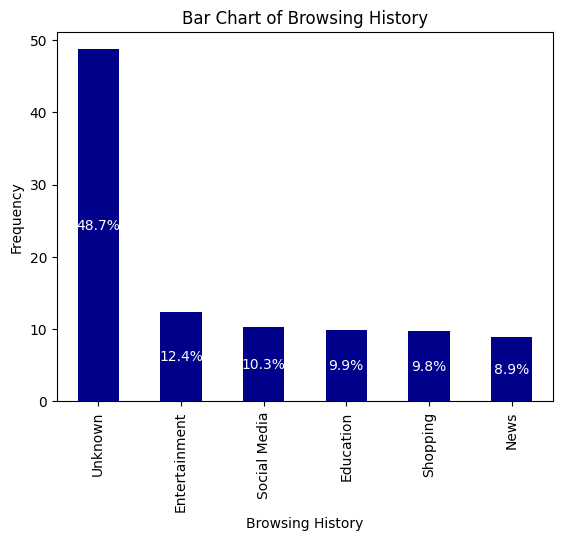

In [34]:
click_counts = data[data['click'] == 1]['browsing_history'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Browsing History')
plt.ylabel('Frequency')
plt.title('Bar Chart of Browsing History')

for i in range(len(click_counts)):
    percentage = click_counts.iloc[i]
    ax.text(i, percentage / 2, f'{percentage:.1f}%', 
            ha='center', va='center', color='white', fontsize=10)

plt.show()

> **Almost 50% of the Browsing History is unknown.**

## Time of Day 

In [35]:
data['time_of_day'].value_counts()

time_of_day
Morning      2126
Afternoon    2016
Unknown      2000
Evening      1958
Night        1900
Name: count, dtype: int64

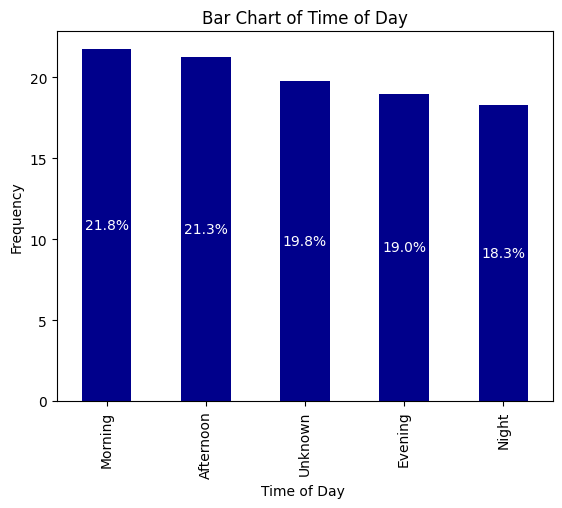

In [36]:
click_counts = data[data['click'] == 1]['time_of_day'].value_counts(normalize=True) * 100
ax = click_counts.plot(kind='bar', color='darkblue')
plt.xlabel('Time of Day ')
plt.ylabel('Frequency')
plt.title('Bar Chart of Time of Day')

for i in range(len(click_counts)):
    percentage = click_counts.iloc[i]
    ax.text(i, percentage / 2, f'{percentage:.1f}%', 
            ha='center', va='center', color='white', fontsize=10)

plt.show()

> **At times of the day, there is not a dramatic difference. There are slightly more ad clicks in the morning and afternoon.**

## Device Type - Ad Position

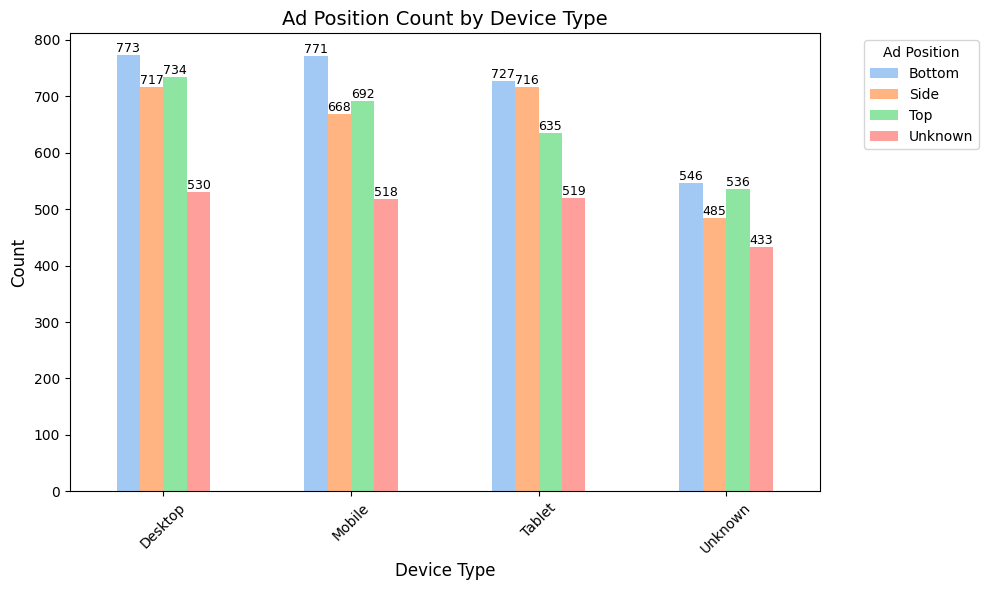

In [37]:
crosstab = pd.crosstab(data['device_type'], data['ad_position'])
ax = crosstab.plot(kind='bar', figsize=(10, 6), color=sns.color_palette("pastel"))

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=9)

plt.xlabel('Device Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Ad Position Count by Device Type', fontsize=14)
plt.legend(title='Ad Position', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

## Device Type - Age

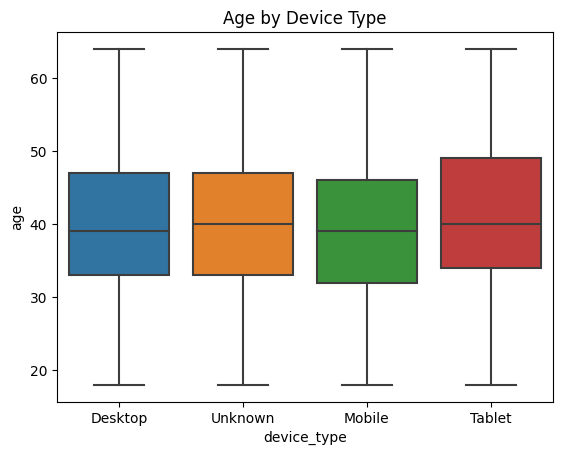

In [38]:
sns.boxplot(x='device_type', y='age', data=data)
plt.title('Age by Device Type')
plt.show()

## Time of Day - Age

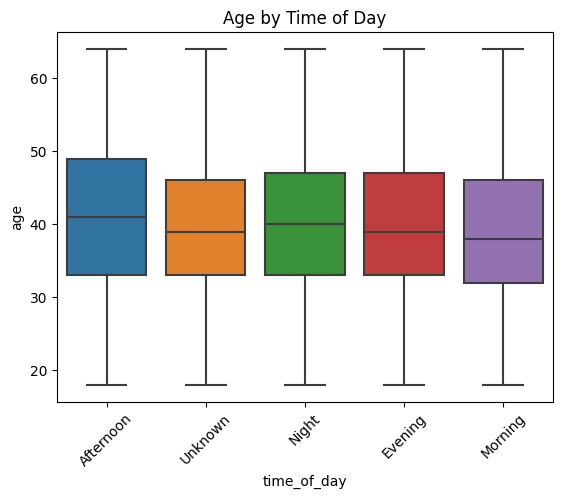

In [39]:
sns.boxplot(x='time_of_day', y='age', data=data)
plt.title('Age by Time of Day')
plt.xticks(rotation=45)
plt.show()

# Skewness

In [40]:
columns = ["age"]

skewed_feats = data[columns].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)


Skew in numerical features: 



,Skew
age,0.147243


**No skewness**

# Encode

In [41]:
for col in cat_cols:
        print('We Have {} Unique values. Values in the {} Column: {}'.format(len(data[col].unique()),col,data[col].unique()))
        print('__'*30)

We Have 4 Unique values. Values in the gender Column: ['Unknown' 'Male' 'Non-Binary' 'Female']
____________________________________________________________
We Have 4 Unique values. Values in the device_type Column: ['Desktop' 'Unknown' 'Mobile' 'Tablet']
____________________________________________________________
We Have 4 Unique values. Values in the ad_position Column: ['Top' 'Side' 'Unknown' 'Bottom']
____________________________________________________________
We Have 6 Unique values. Values in the browsing_history Column: ['Shopping' 'Unknown' 'Education' 'Entertainment' 'Social Media' 'News']
____________________________________________________________
We Have 5 Unique values. Values in the time_of_day Column: ['Afternoon' 'Unknown' 'Night' 'Evening' 'Morning']
____________________________________________________________


In [42]:
data = pd.get_dummies(data, columns=cat_cols.columns, drop_first=True).astype(int)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   age                             10000 non-null  int64
 1   click                           10000 non-null  int64
 2   gender_Male                     10000 non-null  int64
 3   gender_Non-Binary               10000 non-null  int64
 4   gender_Unknown                  10000 non-null  int64
 5   device_type_Mobile              10000 non-null  int64
 6   device_type_Tablet              10000 non-null  int64
 7   device_type_Unknown             10000 non-null  int64
 8   ad_position_Side                10000 non-null  int64
 9   ad_position_Top                 10000 non-null  int64
 10  ad_position_Unknown             10000 non-null  int64
 11  browsing_history_Entertainment  10000 non-null  int64
 12  browsing_history_News           10000 non-null  int64
 13  br

# Models

In [44]:
KNN = data.copy()
XGBoost = data.copy()
LightGBM = data.copy()

## KNN

In [45]:
X = KNN.drop('click', axis=1)
y = KNN['click']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [47]:
smt=SMOTE()
X_train,y_train=smt.fit_resample(X_train,y_train)

### Finding the hyperparameter of KNN

In [48]:
# def objective(trial):
#     # Define hyperparameters
#     n_neighbors = trial.suggest_int('n_neighbors', 1, 20)  # Choose n_neighbors between 1 and 20
#     weights = trial.suggest_categorical('weights', ['uniform', 'distance'])  # Weight types
#     algorithm = trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute'])  # Algorithm types

#     # Create and fit the KNN classifier
#     classifier_knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm)
#     classifier_knn.fit(X_train, y_train)

#     # Make predictions on the test data
#     y_pred = classifier_knn.predict(X_test)

#     # Calculate metrics
#     accuracy_knn = accuracy_score(y_test, y_pred)
#     precision_knn = precision_score(y_test, y_pred)
#     recall_knn = recall_score(y_test, y_pred)
#     f1_knn = f1_score(y_test, y_pred)

#     # Objective: Optimize the F1 score
#     return f1_knn  # We are trying to find the highest F1 score

# # Start the Optuna study
# study = optuna.create_study(direction='maximize')  # For maximum F1 score
# study.optimize(objective, n_trials=30)  # Run 100 trials

# # Print the best parameters and metrics
# print('Best parameters:', study.best_params)
# print('Best F1 Score:', study.best_value)

# # Evaluate with the best model
# best_params = study.best_params
# best_classifier_knn = KNeighborsClassifier(
#     n_neighbors=best_params['n_neighbors'],
#     weights=best_params['weights'],
#     algorithm=best_params['algorithm']
# )

# best_classifier_knn.fit(X_train, y_train)
# best_y_pred = best_classifier_knn.predict(X_test)

# # Print final metrics with the best model
# final_accuracy = accuracy_score(y_test, best_y_pred)
# final_precision = precision_score(y_test, best_y_pred)
# final_recall = recall_score(y_test, best_y_pred)
# final_f1 = f1_score(y_test, best_y_pred)

# print("Final Accuracy:", final_accuracy)
# print("Final Precision:", final_precision)
# print("Final Recall:", final_recall)
# print("Final F1 Score:", final_f1)


+ **Best parameters: {'n_neighbors': 8, 'weights': 'distance', 'algorithm': 'auto'}**

+ Final Accuracy: 0.82

+ Final Precision: 0.8434974283614989

+ Final Recall: 0.8864864864864865

+ Final F1 Score: 0.8644578313253013


In [49]:
classifier_knn = KNeighborsClassifier(n_neighbors = 8, weights='distance', algorithm = 'auto')

classifier_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=8, weights='distance')

In [50]:
cv_scores_knn = cross_val_score(classifier_knn, X, y, cv=5)

print("Cross-validation scores:", cv_scores_knn)
print("Mean CV accuracy:", cv_scores_knn.mean())

Cross-validation scores: [0.809  0.8005 0.8055 0.815  0.8145]
Mean CV accuracy: 0.8089000000000001


In [51]:
y_pred = classifier_knn.predict(X_test)

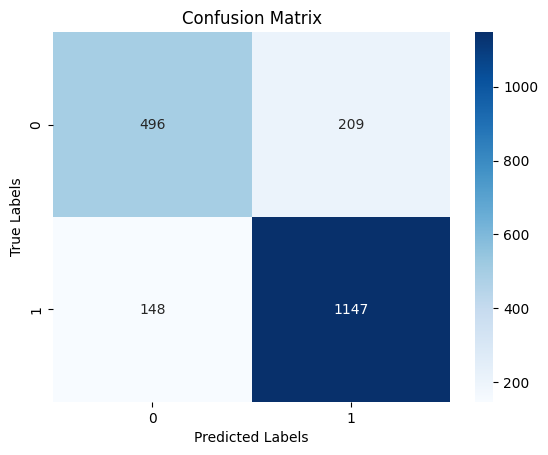

In [52]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [53]:
accuracy_knn = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_knn)

precision_knn = precision_score(y_test, y_pred)
recall_knn = recall_score(y_test, y_pred)

print("Precision:", precision_knn)
print("Recall:", recall_knn)

f1_knn = f1_score(y_test, y_pred)
print("F1 Score:", f1_knn)

Accuracy: 0.8215
Precision: 0.8458702064896755
Recall: 0.8857142857142857
F1 Score: 0.8653338362881932


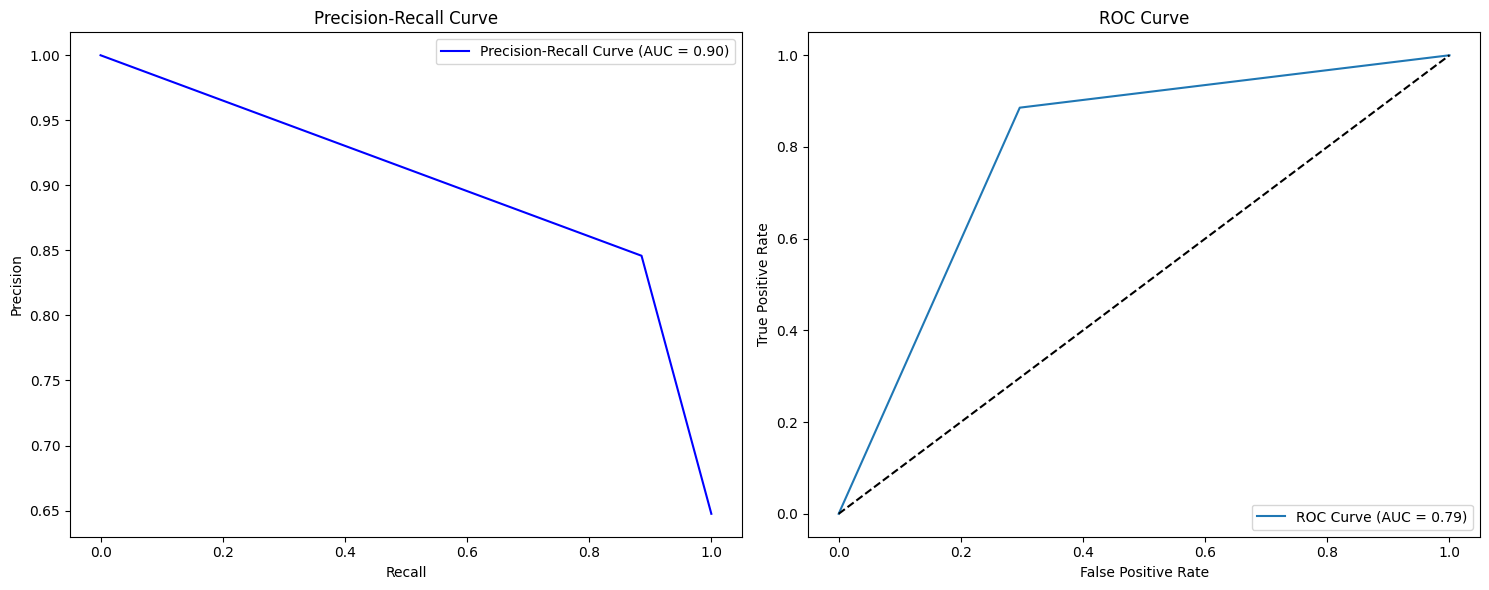

In [54]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_score = auc(recall, precision)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

## XGBoost

In [55]:
X = XGBoost.drop("click", axis=1)
y = XGBoost["click"]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [57]:
smt=SMOTE()
X_train,y_train=smt.fit_resample(X_train,y_train)

### Finding the hyperparameter of XGBoost

In [58]:
# def objective(trial):
#     # Define hyperparameters
#     n_estimators = trial.suggest_int('n_estimators', 50, 200)  # Number of trees
#     max_depth = trial.suggest_int('max_depth', 3, 10)  # Maximum depth of the trees
#     learning_rate = trial.suggest_float('learning_rate', 1e-3, 1, log=True)  # Learning rate
#     subsample = trial.suggest_float('subsample', 0.5, 1.0)  # Subsample ratio

#     # Create and fit the XGBoost classifier
#     classifier_xgb = XGBClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         subsample=subsample,
#         use_label_encoder=False,
#         eval_metric='logloss'  # Evaluation metric for XGBoost
#     )
    
#     classifier_xgb.fit(X_train, y_train)

#     # Make predictions on the test data
#     y_pred = classifier_xgb.predict(X_test)

#     # Calculate metrics
#     f1_xgb = f1_score(y_test, y_pred)

#     # Objective: Optimize the F1 score
#     return f1_xgb  # We are trying to find the highest F1 score

# # Start the Optuna study
# study = optuna.create_study(direction='maximize')  # For maximum F1 score
# study.optimize(objective, n_trials=50)  # Run 100 trials

# # Print the best parameters and metrics
# print('Best parameters:', study.best_params)
# print('Best F1 Score:', study.best_value)

# # Evaluate with the best model
# best_params = study.best_params
# best_classifier_xgb = XGBClassifier(
#     n_estimators=best_params['n_estimators'],
#     max_depth=best_params['max_depth'],
#     learning_rate=best_params['learning_rate'],
#     subsample=best_params['subsample'],
#     use_label_encoder=False,
#     eval_metric='logloss'
# )

# best_classifier_xgb.fit(X_train, y_train)
# best_y_pred = best_classifier_xgb.predict(X_test)

# # Print final metrics with the best model
# final_accuracy = accuracy_score(y_test, best_y_pred)
# final_precision = precision_score(y_test, best_y_pred)
# final_recall = recall_score(y_test, best_y_pred)
# final_f1 = f1_score(y_test, best_y_pred)

# print("Final Accuracy:", final_accuracy)
# print("Final Precision:", final_precision)
# print("Final Recall:", final_recall)
# print("Final F1 Score:", final_f1)

+ **Best parameters: {'n_estimators': 159, 'max_depth': 10, 'learning_rate': 0.25613125850918106, 'subsample': 0.694175554019842}**

+ Best F1 Score: 0.8815201192250373

+ Final Accuracy: 0.841

+ Final Precision: 0.8547687861271677

+ Final Recall: 0.91

+ Final F1 Score: 0.8815201192250373

In [59]:
classifier_xgb = XGBClassifier(n_estimators=159, max_depth=10, learning_rate=0.25613125850918106, subsample=0.694175554019842)

classifier_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25613125850918106,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=159, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [60]:
cv_scores_xgb = cross_val_score(classifier_xgb, X, y, cv=5)

print("Cross-validation scores:", cv_scores_xgb)
print("Mean CV accuracy:", cv_scores_xgb.mean())

Cross-validation scores: [0.8425 0.8465 0.8395 0.8425 0.833 ]
Mean CV accuracy: 0.8408000000000001


In [61]:
y_pred = classifier_xgb.predict(X_test)

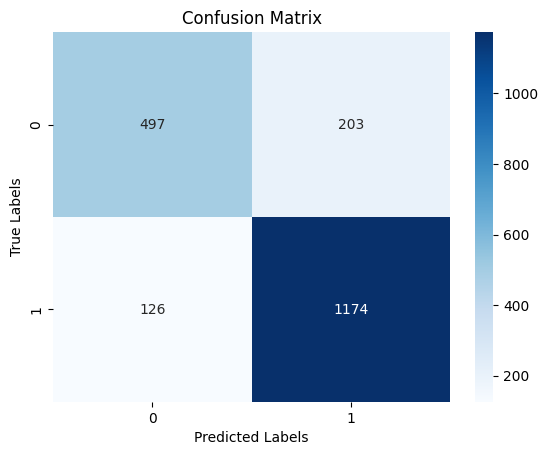

In [62]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [63]:
accuracy_xgb = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_xgb)

precision_xgb = precision_score(y_test, y_pred)
recall_xgb = recall_score(y_test, y_pred)

print("Precision:", precision_xgb)
print("Recall:", recall_xgb)

f1_xgb = f1_score(y_test, y_pred)
print("F1 Score:", f1_xgb)

Accuracy: 0.8355
Precision: 0.8525780682643428
Recall: 0.9030769230769231
F1 Score: 0.8771012327231976


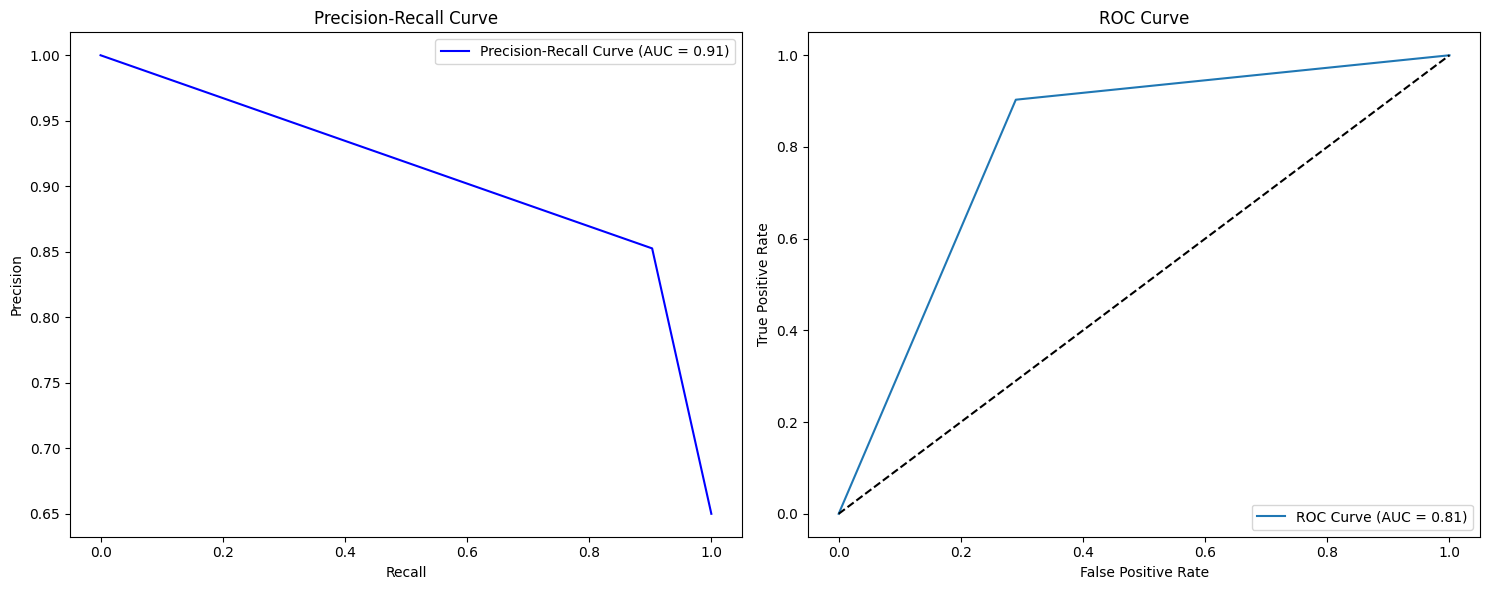

In [64]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_score = auc(recall, precision)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

## LightGBM

In [65]:
X = LightGBM.drop("click", axis=1)
y = LightGBM["click"]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [67]:
smt=SMOTE()
X_train,y_train=smt.fit_resample(X_train,y_train)

### Finding the hyperparameter of LightGBM

In [68]:
# def objective(trial):
#     # Define hyperparameters
#     num_leaves = trial.suggest_int('num_leaves', 20, 150)  # Number of leaves
#     learning_rate = trial.suggest_float('learning_rate', 1e-3, 1, log=True)  # Learning rate
#     n_estimators = trial.suggest_int('n_estimators', 50, 200)  # Number of boosting iterations
#     max_depth = trial.suggest_int('max_depth', -1, 20)  # Maximum tree depth (-1 means no limit)

#     # Create and fit the LightGBM classifier
#     classifier_lgb = lgb.LGBMClassifier(
#         objective='binary',
#         learning_rate=learning_rate,
#         num_leaves=num_leaves,
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         random_state=42,
#         verbose=-1# For reproducibility
#     )
    
#     classifier_lgb.fit(X_train, y_train)

#     # Make predictions on the test data
#     y_pred = classifier_lgb.predict(X_test)

#     # Calculate metrics
#     f1_lgb = f1_score(y_test, y_pred)

#     # Objective: Optimize the F1 score
#     return f1_lgb  # We are trying to find the highest F1 score

# # Start the Optuna study
# study = optuna.create_study(direction='maximize')  # For maximum F1 score
# study.optimize(objective, n_trials=50)  # Run 100 trials

# # Print the best parameters and metrics
# print('Best parameters:', study.best_params)
# print('Best F1 Score:', study.best_value)

# # Evaluate with the best model
# best_params = study.best_params
# best_classifier_lgb = lgb.LGBMClassifier(
#     objective='binary',
#     learning_rate=best_params['learning_rate'],
#     num_leaves=best_params['num_leaves'],
#     n_estimators=best_params['n_estimators'],
#     max_depth=best_params['max_depth'],
#     random_state=42
# )

# best_classifier_lgb.fit(X_train, y_train)
# best_y_pred = best_classifier_lgb.predict(X_test)

# # Print final metrics with the best model
# final_accuracy = accuracy_score(y_test, best_y_pred)
# final_precision = precision_score(y_test, best_y_pred)
# final_recall = recall_score(y_test, best_y_pred)
# final_f1 = f1_score(y_test, best_y_pred)

# print("Final Accuracy:", final_accuracy)
# print("Final Precision:", final_precision)
# print("Final Recall:", final_recall)
# print("Final F1 Score:", final_f1)

+ **Best parameters: {'num_leaves': 116, 'learning_rate': 0.4387373712573615, 'n_estimators': 170, 'max_depth': 0}**
+ Final Accuracy: 0.8395
+ Final Precision: 0.8513998564249821
+ Final Recall: 0.9123076923076923
+ Final F1 Score: 0.8808020794652804

In [69]:
classifier_lgb = lgb.LGBMClassifier(
    num_leaves=116,
    learning_rate=0.4387373712573615,
    n_estimators=170,
    max_depth=0,
    verbose=-1
)

classifier_lgb.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.4387373712573615, max_depth=0, n_estimators=170,
               num_leaves=116, verbose=-1)

In [70]:
cv_scores_lgb = cross_val_score(classifier_lgb, X, y, cv=5)

print("Cross-validation scores:", cv_scores_lgb)
print("Mean CV accuracy:", cv_scores_lgb.mean())

Cross-validation scores: [0.8355 0.8445 0.852  0.835  0.837 ]
Mean CV accuracy: 0.8408


In [71]:
y_pred = classifier_lgb.predict(X_test)

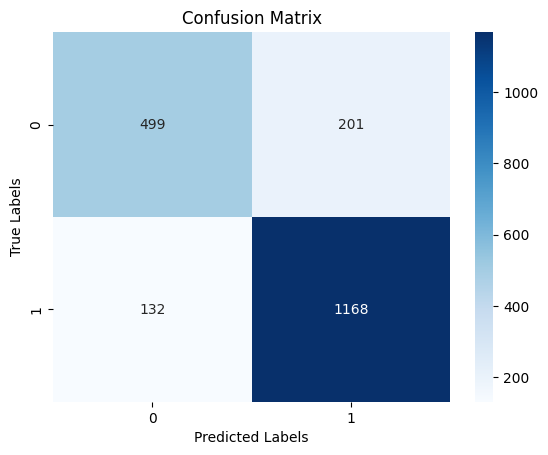

In [72]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [73]:
accuracy_lgb = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_lgb)

precision_lgb = precision_score(y_test, y_pred)
recall_lgb = recall_score(y_test, y_pred)

print("Precision:", precision_xgb)
print("Recall:", recall_lgb)

f1_lgb = f1_score(y_test, y_pred)
print("F1 Score:", f1_lgb)

Accuracy: 0.8335
Precision: 0.8525780682643428
Recall: 0.8984615384615384
F1 Score: 0.8752341701011614


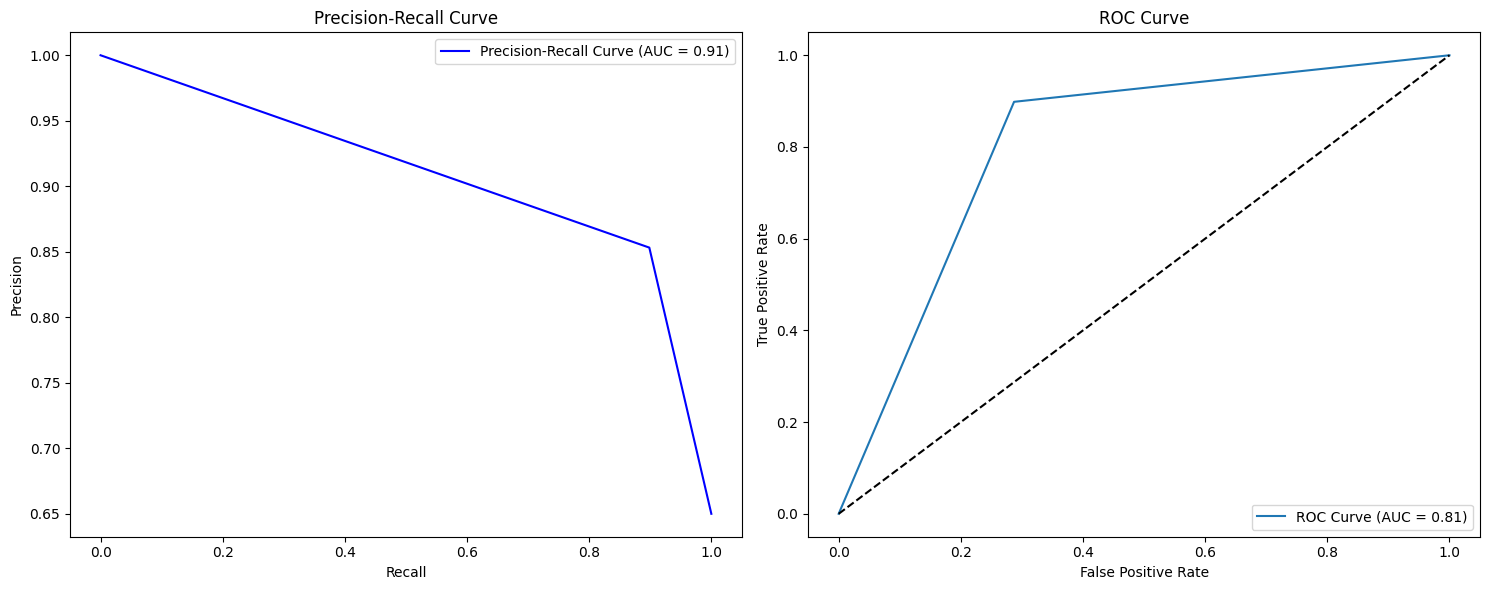

In [74]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)
auc_score = auc(recall, precision)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {auc_score:.2f})', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# All Model Metrics

In [75]:
model_metrics_list = []

model_metrics_list.append({
    'Model': 'KNN',
    'Accuracy': accuracy_knn,
    'Precision': precision_knn,
    'Recall': recall_knn,
    'F1 Score': f1_knn,
    'Mean CV Accuracy': cv_scores_knn.mean()
})

model_metrics_list.append({
    'Model': 'XGBoost',
    'Accuracy': accuracy_xgb,
    'Precision': precision_xgb,
    'Recall': recall_xgb,
    'F1 Score': f1_xgb,
    'Mean CV Accuracy': cv_scores_xgb.mean()
})

model_metrics_list.append({
    'Model': 'LightGBM',
    'Accuracy': accuracy_lgb,
    'Precision': precision_lgb,
    'Recall': recall_lgb,
    'F1 Score': f1_lgb,
    'Mean CV Accuracy': cv_scores_lgb.mean()
})

all_metrics_df = pd.DataFrame(model_metrics_list)

all_metrics_df

,Model,Accuracy,Precision,Recall,F1 Score,Mean CV Accuracy
0,KNN,0.8215,0.845870,0.885714,0.865334,0.8089
1,XGBoost,0.8355,0.852578,0.903077,0.877101,0.8408
2,LightGBM,0.8335,0.853178,0.898462,0.875234,0.8408


In [2]:
import numpy as np
import pandas as pd
array = np.load('/home/bob/MLOps/Ad-Click-Prediction-MLOps/artifact/01_05_2025_17_50_52/data_transformation/transformed/train.npy')

df = pd.DataFrame(array)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-1.496051,0.130435,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.459706,0.582609,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.700860,0.869565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.418780,0.804348,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.888914,0.913043,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
